## Preface



First, if you don&rsquo;t already have the latest version of the `cfe` package
installed, grab it, along with some dependencies:



In [1]:
!pip install CFEDemands --upgrade --pre
!pip install xarray --upgrade
!pip install h5netcdf

Second, load relevant dataset:



In [1]:
import cfe

# Results can be made persistent by saving them, and then re-loading...
r = cfe.from_dataset('./Indian ICRISAT_small.ds')

r['alpha'] = r.alpha.loc[r.alpha>0]  # Insist on alpha positive

## Choosing reference prices, budget, and units



We&rsquo;ll want to choose reference prices (a choice of `t` and `m`) and
units (`u`).  You can examine possibilities by looking at:



In [1]:
r.prices.coords

Below we choose first market in first period, but this is a matter of
choice.  We also choose prices for goods measured in &rsquo;Kilograms&rsquo;; this
may vary with the dataset.  To inspect possible units look at:



In [1]:
t = r.firstround  # First round
m = r.coords['m'][0] # First market

# Get median budget
x = r.get_predicted_expenditures().sum('i')
medianx = x.where(x>0).sel(t=t,m=m).median('j').values

# Note selection of prices for first market in first period for /kgs/.
# For goods never measured in kgs prices will be missing. 
p = r.prices.sel(t=t,m=m,u='Kilograms',drop=True).to_dataframe().squeeze().dropna()
p

And with $(x,p)$ defined we can calculate example demands:



In [1]:
# Expenditures divided by reference prices per Kilogram
c=(r.demands(medianx)/p).dropna()
c

## Mapping to Nutrients



We&rsquo;ve seen how to map prices and budgets into vectors of consumption
quantities using `cfe.Result.demands`.  Next we want to think about
how to map these into bundles of *nutrients*.  The information needed
for the mapping comes from a &ldquo;Food Conversion Table&rdquo; (or database,
such as the [USDA Food Central Database](https://fdc.nal.usda.gov/)).   Here we&rsquo;ve adapted (with
thanks to Alessandro Tarozzi of the Universitat Pompeu Fabra) a food
conversion table developed by Gopalan et al (1980) to the foods
reported in the Indian ICRISAT data:



In [1]:
import pandas as pd
import numpy as np

# The function below adapted from Gianmario Spacagna's suggestion at
# https://stackoverflow.com/questions/19611729/getting-google-spreadsheet-csv-into-a-pandas-dataframe
def dataframe_from_gspreadsheet(sheet_name, key):
    """Transform public google spreadsheet into pandas.DataFrame."""
    
    url = 'https://docs.google.com/spreadsheets/d/{key}/gviz/tq?tqx=out:csv&sheet={sheet_name}&headers=1'.format(
        key=key, sheet_name=sheet_name.replace(' ', '%20'))

    df = pd.read_csv(url)

    return df.drop([col for col in df.columns if col.startswith('Unnamed')], axis=1)

# Change 'ICRISAT' sheet id to that of your own sheet
fct = dataframe_from_gspreadsheet("FCT", '13Ig5hZif-NSHtgkKRp_cEgKXk0lOsdUB2BAD6O_FnRo')


# Change some labels
d={'protein':'Protein',
   'protein g':'Protein',
   'fat':'Fat',
   'energy_kcal':'Calories',
   'energy kcal':'Calories',
   'calcium':'Calcium',
   'ca mg':'Calcium',
   'betacarotene':'Betacarotene',
   'thiamine':'Thiamine',
   'riboflavin':'Riboflavin',
   'niacin':'Niacin',
   'iron':'Iron',
   'fe mg':'Iron',
   'ascorbic_total':'Ascorbic Acid',
   'vit a ug':'Vitamin A',
   'vit b6 mg':'Vitamin B6',
   'vit b12 ug':'Vitamin B12',
   'vit d ug':'Vitamin D',
   'vit e ug':'Vitamin E',
   'vit c mg':'Vitamin C',
   'mg mg':'Magnesium',
   'zn mg':'Zinc'}

fct = fct.rename(columns=d) #[list(d.values())]

# Fix capitalization (to match food labels)
fct.index = fct.reset_index()['i'].str.title()
del fct['i']
del fct['ext_source']

# Replace missing with zeros
fct = fct.fillna(0)

try:
    fct.index = fct.index.droplevel('u')
except (AttributeError,KeyError):
    pass # No units?

fct.columns

We need the index of the Food Conversion Table (FCT) to match up with
the index of the vector of quantities demanded.   To manage this we
make use of the `align` method for `pd.DataFrames`:



In [1]:
# Create a new FCT and vector of consumption that only share rows in common:
fct0,c0 = fct.align(c,axis=0,join='inner')
print(fct0.index)

Now, since rows of `fct0` and `c0` match, we can obtain nutritional
outcomes from the inner (or dot, or matrix) product of the transposed
`fct0` and `c0`:



In [1]:
# The @ operator means matrix multiply
N = fct0.T@c0
N

Of course, since we can compute the nutritional content of a vector of
consumption goods `c0`, we can also use our demand functions to
compute nutrition as a *function* of prices and budget.



In [1]:
def nutrient_demand(x,pscale=None,p=p):
    c = (r.demands(x,p=pscale)/p).dropna()
    fct0,c0 = fct.align(c,axis=0,join='inner')
    N = fct0.T@c0

    return N

With this `nutrient_demand` function in hand, we can see how nutrient
outcomes vary with budget, given prices:



Text(0, 0.5, 'log nutrient')

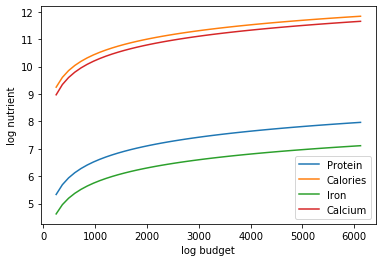

In [28]:
import numpy as np
import matplotlib.pyplot as plt

X = np.linspace(medianx/5,medianx*5,50).tolist()

UseNutrients = ['Protein','Calories','Iron','Calcium']

# Use reference prices
logN={}
for myx in X:
    logN[myx] = np.log(nutrient_demand(myx)[UseNutrients])
    
logN = pd.concat(logN,axis=1).T

plt.plot(X,logN)
plt.legend(UseNutrients)
plt.xlabel('log budget')
plt.ylabel('log nutrient')

Now how does nutrition vary with prices at median income?



Text(0.5, 0, 'log Nutrient')

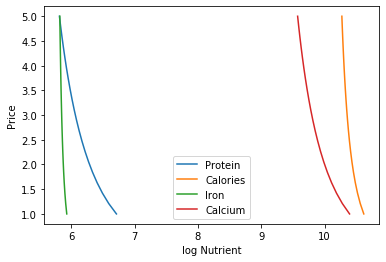

In [29]:
# Choose some good from your dataset
USE_GOOD = 'Milk'

P = np.linspace(1,5,20).tolist()

plt.plot(pd.concat({p0:np.log(nutrient_demand(medianx,pscale={USE_GOOD:p0})[UseNutrients]) for p0 in P},axis=1).T,P)
plt.legend(UseNutrients)
plt.ylabel('Price')
plt.xlabel('log Nutrient')

## Nutritional Adequacy



### Nutritional requirements



Individuals have nutritional requirements established by nutrition
 scientists.  Here are some standards established by the Indian
 National Institute of Nutrition:



#### Recommended Daily Allowances: India (Individuals)



| Sex-Age|Calories|Protein|Fat|Calcium|Iron|Betacarotene|Thiamine|Riboflavin|Niacin|Ascorbic Acid|
|---|---|---|---|---|---|---|---|---|---|---|
| C 0-0.5||||500|||.2|.3||25|
| C 0.5-1|||19|500|5|2800|.3|.4||25|
| C 1-3|1060|16.7|27|600|9|3200|.5|.6|8|40|
| C 4-6|1350|20.1|25|600|13|3200|.7|.8|11|40|
| C 7-9|1690|29.5|30|600|16|4800|.8|1.|13|40|
| B 10-12|2190|39.9|35|800|21|4800|1.1|1.3|15|40|
| G 10-12|2010|40.4|35|800|27|4800|1.|1.2|13|40|
| B 13-15|2750|54.3|45|800|32|4800|1.4|1.6|16|40|
| G 13-15|2330|51.9|40|800|27|4800|1.2|1.4|14|40|
| B 16-17|3020|61.5|50|800|28|4800|1.5|1.8|17|40|
| G 16-17|2440|55.5|35|800|26|4800|1.|1.2|14|40|
| M|2730|60|30|600|17|4800|1.4|1.4|18|40|
| W|2230|55|25|1200|21|4800|1.1|1.3|14|40|



### Nutritional Needs of Households



Our data on demand and nutrients is at the *household* level; we
   can&rsquo;t directly compare household level nutrition with individual
   level requirements.  What we **can** do is add up minimum individual
   requirements, and see whether household total exceed these.  This
   isn&rsquo;t a guarantee that all individuals have adequate nutrition
   (since the way food is allocated in the household might be quite
   unequal, or unrelated to individual requirements), but it is
   *necessary* if all individuals are to have adequate nutrition.

For the average household in the ICRISAT villages, the number of
different kinds of people can be computed by averaging over households:



In [30]:
# In first round, averaged over households and villages

zbar = r.z.sel(t=r.firstround,drop=True).mean(['j','m'])[:-1].squeeze() # Leave out log HSize

zbar = zbar.to_dataframe().squeeze()
zbar

k
M 0-3      0.373444
F 0-3      0.336100
M 4-8      0.468880
F 4-8      0.402490
M 9-13     0.381743
F 9-13     0.344398
M 14-18    0.373444
F 14-18    0.248963
M 19-30    0.572614
F 19-30    0.493776
M 31-50    0.701245
F 31-50    0.713693
M 51+      0.269710
F 51+      0.286307
Name: z, dtype: float64

Now, the inner/dot/matrix product between `zbar` and the `rda`
DataFrame of requirements will give us minimum requirements for the
average household:



In [31]:
rda = pd.read_pickle('indian_rda.df').T

# May need to tweak types to match RDA and zbar types:
zbar['C 0-3'] = zbar['M 0-3'] + zbar['F 0-3']
zbar['C 4-8'] = zbar['M 4-8'] + zbar['F 4-8']
zbar['M'] = zbar['M 19-30'] + zbar['M 31-50'] + zbar['M 51+']
zbar['F'] = zbar['F 19-30'] + zbar['F 31-50'] + zbar['F 51+']
zbar = zbar[['C 0-3','C 4-8','M 9-13','F 9-13','M 14-18','F 14-18','M','F']]

rda = rda.replace('',0)

rda['C 0-3'] = rda['C 0-0.5'] + rda['C 0.5-1'] + rda['C 1-3']
rda['C 4-8'] = rda['C 4-6'] + rda['C 7-9']
rda['M 9-13'] = rda['B 10-12']
rda['F 9-13'] = rda['G 10-12']
rda['M 14-18'] = rda['B 13-15'] + rda['B 16-17']
rda['F 14-18'] = rda['G 13-15'] + rda['G 16-17']
rda['F'] = rda['W']

rda = rda[['C 0-3','C 4-8','M 9-13','F 9-13','M 14-18','F 14-18','M','F']]

# This matrix product gives minimum nutrient requirements for average
# household in 1975
hh_rda = rda@zbar
hh_rda

Calories         15816.721992
Protein            328.969710
Fat                243.780083
Calcium           6476.348548
Iron               145.730290
Betacarotene     35268.049793
Thiamine             8.215768
Riboflavin           9.420332
Niacin             104.784232
Ascorbic Acid      333.900415
dtype: float64

## Nutritional Adequacy of Food Demands



Since we can trace out demands for nutrients as a function of $(x,p)$,
and we&rsquo;ve computed minimum nutritional requirements for the average
household, we can *normalize* nutritional intake to check the adequacy
of diet.



In [32]:
def nutrient_adequacy_ratio(x,pscale=None):
    return nutrient_demand(x,pscale=pscale)/hh_rda

In terms of normalized nutrients, any household with more than one
unit of any given nutrient (or zero in logs) will be consuming a
minimally adequate level of the nutrient; below this level there&rsquo;s
clearly nutritional inadequacy.  For this reason the ratio of
actual nutrients to required nutrients is termed the &ldquo;nutrient
adequacy ratio,&rdquo; or NAR.



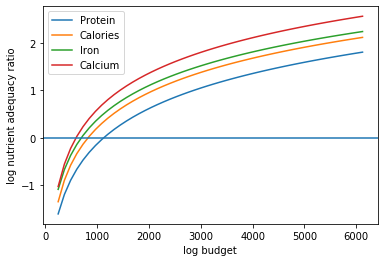

In [33]:
plt.plot(X,pd.concat({x:np.log(nutrient_adequacy_ratio(x,p))[UseNutrients] for x in X},axis=1).T)
plt.legend(UseNutrients)
plt.xlabel('log budget')
plt.ylabel('log nutrient adequacy ratio')
plt.axhline(0)